# MAGIC AI Workshop 01 Introduction to machine learning



In this lab, we will introduce the basics of machine learning in R. We'll cover some data exploration, designing a machine learning workflow (including a cross-validation strategy and performance metric) and look at how to try different algorithms. We'll also look briefly at making predictions with our model and exploring the results of the model. 

Before starting, we'll define some vocabulary for the process of ML model building:

- Outcome or target: the variable that we are interested in predicting. The equivalent to covariates in a regression model
- Features: the variables we will use to predict the outcome. Equivalent to covariates in regression models
- Training: the process of estimating model weights
- Loss function: a measure of how well the predicted outcome ($\hat{y}$) maps to the observed outcome ($y$)
- Performance metric: a measure of how well the model can predict for an *independent* dataset
- Model weights: one or more values that are used to map the features to the outcome. The value of these is learned during the training process
- Hyperparameters: algorithm-specific parameters that control the way that the algorithm learns or updates the weights

The data we will use contains daily counts of rented bicycles from the bicycle rental company Capital-Bikeshare in Washington D.C., along with weather and seasonal information. Our goal is to build a model to predict the count of bikes rented on any given day (the count is the outcome). Before starting the lab, you will need to set up a new folder for your working directory. Download the file *bike.csv* from github and move it to this folder. Now start R or Rstudio and set your working directory to this folder (if you're not sure how to do this, please ask). 

In this lab, we will introduce **scikit-learn**, a widely used toolkit for machine learning in Python. This provides a standard interface managing a machine learning workflow, including setting up training and testing data, running different algorithms and evaluating the models. You'll also need the following packages: `numpy`, `pandas` and `matplotlib`. Make sure these are installed using your favorite package manager (pip or conda)

Let's start by importing the packages that we will need

In [171]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

## Data

We'll start by loading the data and carrying out some simple exploration. 

In [172]:
bike = pd.read_csv("../datafiles/bike.csv")
bike.shape

(731, 12)

In [173]:
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,count,days_since_2011
0,WINTER,2011,JAN,NO HOLIDAY,SAT,NO WORKING DAY,MISTY,8.175849,80.5833,10.749882,985,0
1,WINTER,2011,JAN,NO HOLIDAY,SUN,NO WORKING DAY,MISTY,9.083466,69.6087,16.652113,801,1
2,WINTER,2011,JAN,NO HOLIDAY,MON,WORKING DAY,GOOD,1.229108,43.7273,16.636703,1349,2
3,WINTER,2011,JAN,NO HOLIDAY,TUE,WORKING DAY,GOOD,1.400000,59.0435,10.739832,1562,3
4,WINTER,2011,JAN,NO HOLIDAY,WED,WORKING DAY,GOOD,2.666979,43.6957,12.522300,1600,4


Now, use the `describe()` method to get some basic summary statistics

In [174]:
bike.describe()

,yr,temp,hum,windspeed,count,days_since_2011
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,2011.500684,15.283085,62.789406,12.762576,4504.348837,365.000000
std,0.500342,8.603397,14.242910,5.192357,1937.211452,211.165812
min,2011.000000,-5.220871,0.000000,1.500244,22.000000,0.000000
25%,2011.000000,7.842925,52.000000,9.041650,3152.000000,182.500000
50%,2012.000000,15.421651,62.666700,12.125325,4548.000000,365.000000
75%,2012.000000,22.804575,73.020850,15.625371,5956.000000,547.500000
max,2012.000000,32.498349,97.250000,34.000021,8714.000000,730.000000


We'll now make some plots to take a look at how the features relate to the count of rental bikes. First, let's plot the time series of daily rentals. This shows a couple of things: a clear seasonal cycle and a long-term trend across the two years:

<Axes: xlabel='days_since_2011', ylabel='count'>

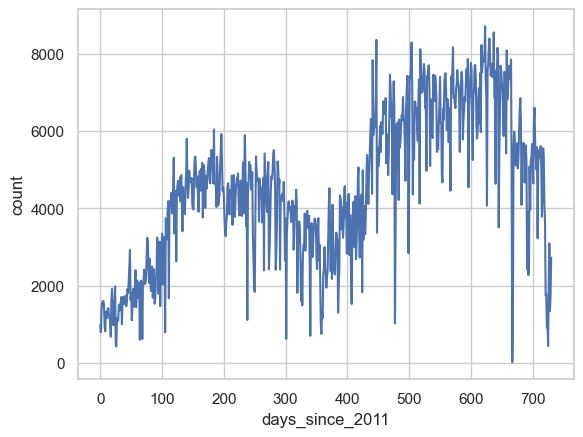

In [175]:
#plt.plot(bike['days_since_2011'], bike['count'])
sns.set_theme(style="whitegrid")
sns.lineplot(bike, x='days_since_2011', y='count')

We can also look at the distribution by day of the week, month, holiday, etc. 

<Axes: xlabel='weekday', ylabel='count'>

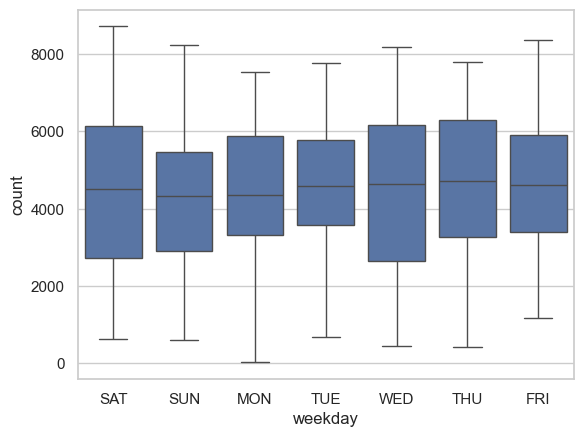

In [176]:
sns.boxplot(bike, x='weekday', y='count')

<Axes: xlabel='mnth', ylabel='count'>

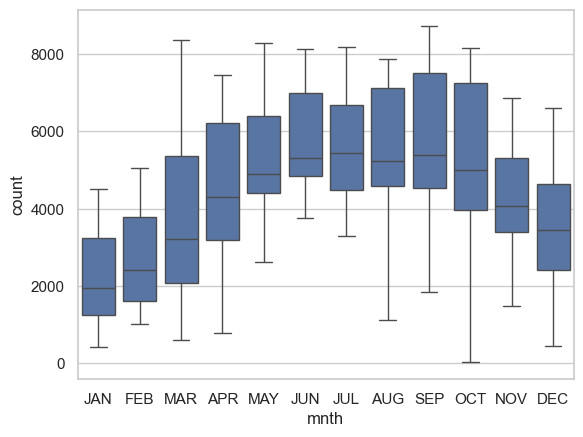

In [177]:
sns.boxplot(bike, x='mnth', y='count')

And by holiday

<Axes: xlabel='holiday', ylabel='count'>

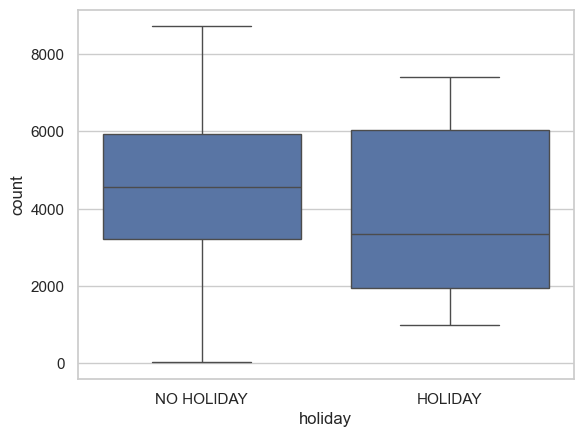

In [178]:
sns.boxplot(bike, x='holiday', y='count')

Again we can see the clear seasonal cycle, as well as a slightly higher rate on non-holdiays. There's little to no variation across week days however. We can also use some scatter plots to show the relationship of rentals to environmental features:

<Axes: xlabel='temp', ylabel='count'>

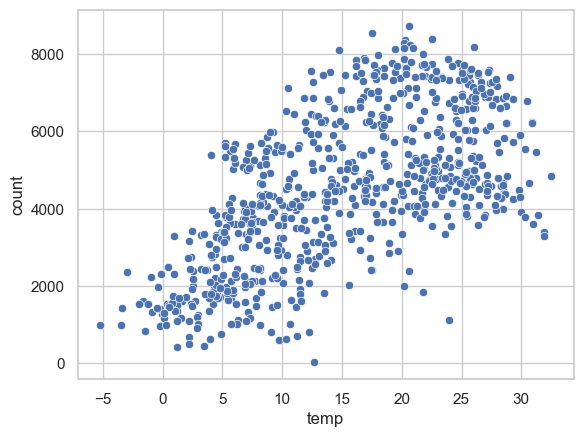

In [179]:
sns.scatterplot(bike, x='temp', y='count')

<Axes: xlabel='hum', ylabel='count'>

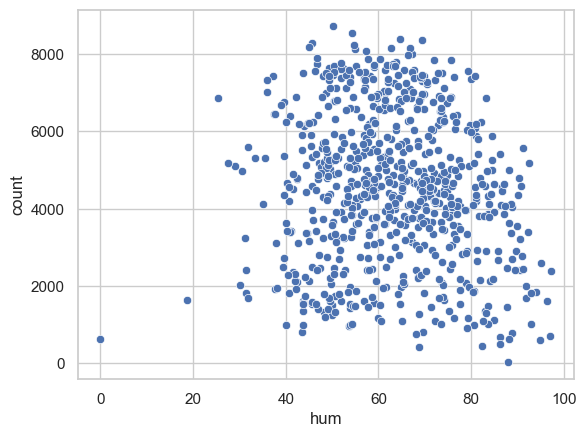

In [180]:
sns.scatterplot(bike, x='hum', y='count')

<Axes: xlabel='windspeed', ylabel='count'>

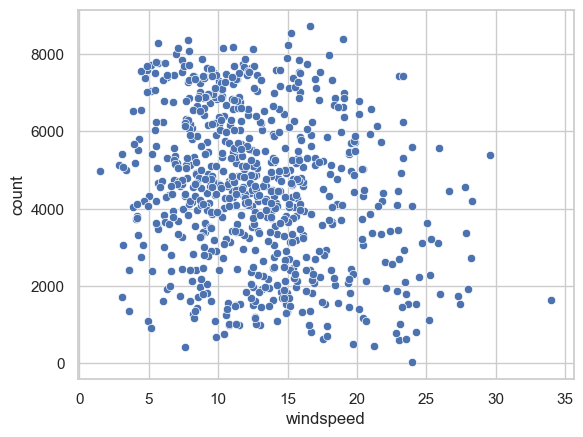

In [181]:
sns.scatterplot(bike, x='windspeed', y='count')

It's difficult to make out much in the humidity and windspeed plots, except that rentals appear to decline at higher values. Rentals generally increase with temperature, but appear to decline at higher temps. Most of this makes sense: cycling in high wind speed or hot, humid conditions is generally less appealing. The data also contain a more general 'weather type' categorical variable that we can use:

<Axes: xlabel='weathersit', ylabel='count'>

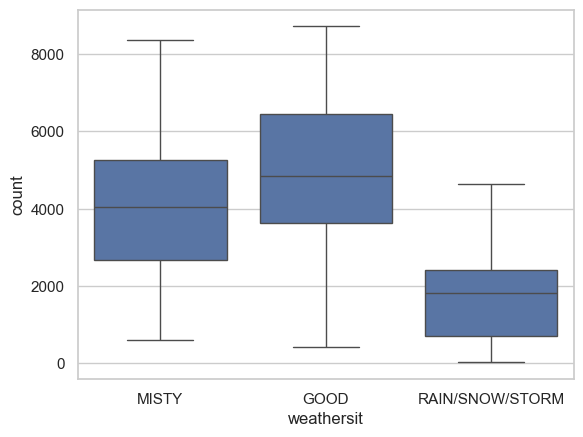

In [182]:
sns.boxplot(bike, x='weathersit', y='count')

## Machine learning


We'll now build a machine learning model with these data. We'll model the rental numbers using the environmental data, months and holiday/non-holiday variables. 

The general steps in constructing any ML model are:

- Preprocess data
- Set up cross-validation strategy
- Train (and optionally tune) the model
- Estimate the predictive skill through cross-validation

### Preprocessing
Prior to building a model, we will want to clean the data to help optimize the training process and the predictive skill of the model. Some things to check for are:

- Outliers in the outcome variable
- Missing values
- High correlations between features

This dataset has already been cleaned so there is relatively little to do in processing it before building models. However, the plots above showed an observation with a relative humidity value of 0, which is likely an error, so we'll now remove these:

In [183]:
bike2 = bike[bike['hum']>0]

The standard approach to scikit learn is to divide the data into two new arrays `X`, containing the features and `y` containing the targets or outcome values. We'll do this here by first choosing the features we want, then selecting these out into a new DataFrame

In [184]:
sel_features = ['temp', 'hum', 'windspeed', 'mnth', 'holiday', 'weathersit']
X = bike2[sel_features]

Next, we need to convert our categorical features to dummy variables (also called one-hot encoding). This converts them from their original values (e.g. JAN/FEB/MAR) to a set of binary features - one per class. For example, with the monthly data, we'll create 12 new features, one per month. The one for January will have 1's for all Jan observations and 0's for all other months, etc. To illustrate, let's run this just with the monthly column:

In [185]:
pd.get_dummies(X['mnth'], dtype=int)

,APR,AUG,DEC,FEB,JAN,JUL,JUN,MAR,MAY,NOV,OCT,SEP
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
726,0,0,1,0,0,0,0,0,0,0,0,0
727,0,0,1,0,0,0,0,0,0,0,0,0
728,0,0,1,0,0,0,0,0,0,0,0,0
729,0,0,1,0,0,0,0,0,0,0,0,0


We'll now transform all cateogrical variables. We'll add one further argument (`drop_first=True`). This removes the first column for each set of dummy variables to prevent issues of collinearity in the data. 

In [186]:
X = pd.get_dummies(X, dtype=int, drop_first=True)

In [187]:
X

,temp,hum,windspeed,mnth_AUG,mnth_DEC,mnth_FEB,mnth_JAN,mnth_JUL,mnth_JUN,mnth_MAR,mnth_MAY,mnth_NOV,mnth_OCT,mnth_SEP,holiday_NO HOLIDAY,weathersit_MISTY,weathersit_RAIN/SNOW/STORM
0,8.175849,80.5833,10.749882,0,0,0,1,0,0,0,0,0,0,0,1,1,0
1,9.083466,69.6087,16.652113,0,0,0,1,0,0,0,0,0,0,0,1,1,0
2,1.229108,43.7273,16.636703,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,1.400000,59.0435,10.739832,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,2.666979,43.6957,12.522300,0,0,0,1,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,3.945849,65.2917,23.458911,0,1,0,0,0,0,0,0,0,0,0,1,1,0
727,3.906651,59.0000,10.416557,0,1,0,0,0,0,0,0,0,0,0,1,1,0
728,3.906651,75.2917,8.333661,0,1,0,0,0,0,0,0,0,0,0,1,1,0
729,4.024151,48.3333,23.500518,0,1,0,0,0,0,0,0,0,0,0,1,0,0


The last thing to do is extract the target (the rental counts) into a new vector called `y`:

In [188]:
y = bike2['count']

### Cross-validation strategy

As the majority of ML algorithms have no built in diagnostics, similar to those found in traditional statistical models, we need a different approach to assess our models. Cross-validation refers to the process of dividing the data into two subsets:

- The training set is used to build or train the model. Training selects models weights that minimize the loss function (and therefore maximize the fit of the model to the training data). 
- The test set is used to assess the model. Once the model weights have been established, the trained model is used to predict the outcome for this set. The difference between predicted and observed value is assessed using the performance metric. 

There are several different ways to create the training and test set. Here, we'll use a simple hold-out method. We use `train_test_split` to select a proportion of the original data to go into the training set (controlled by the argument `train_size=0.8`). This returns four objects: the features for training (`X_train`), the features for testing (`X_test`), the target for training (`y_train`) and the target for testing (`y_test`).

In [189]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8)

Check the sizes (the test should be roughly 1/4 the size of the training set):

In [190]:
print(X_train.shape)
print(X_test.shape)

(584, 17)
(146, 17)


### Training the model

Now we can go ahead and train a model. We'll start by using a simple linear regression model. These are considered to be included in machine learning algorithms (much to the annoyance of most statisticians). While these tend not to perform as well as more complex algorithms (tree methods, neural networks, etc), they are useful in providing a baseline model that complex models should improve on. 

This also demonstrate the usual method for fitting models with scikit-learn. First we *instantiate* an algorithm. This defines a blank model that can then be trained. For linear regression, we use the `LinearRegression()` method from scikit-learn's linear models

In [191]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()

Next we use the `fit` method from the instantiated model to train with our training data 

In [192]:
lin_reg.fit(X_train, y_train)

LinearRegression()

Once trained, the model contains a series of coefficients or weights for each feature. We can make this into a table to show the values:

In [193]:
cdf = pd.DataFrame(lin_reg.coef_, X_train.columns, columns=['Coefficients'])
print(cdf)

                            Coefficients
temp                          150.242492
hum                           -36.651656
windspeed                     -61.628074
mnth_AUG                     -507.372376
mnth_DEC                      296.812833
mnth_FEB                     -679.887369
mnth_JAN                     -694.524828
mnth_JUL                     -991.215897
mnth_JUN                     -433.982799
mnth_MAR                       63.592384
mnth_MAY                      215.907005
mnth_NOV                      476.707997
mnth_OCT                      996.257956
mnth_SEP                      650.989354
holiday_NO HOLIDAY            633.110173
weathersit_MISTY              -89.415909
weathersit_RAIN/SNOW/STORM  -1536.733450


In [194]:
lin_reg.intercept_

4816.494703326768

The `score()` method will return the coefficient of determination ($R^2$)

In [195]:
print(lin_reg.score(X_train, y_train))

0.5755834351802017


In a statistical model, we'd spend some time looking at the coefficients, standard errors and $p$-values. In a ML model, we more interested in the predictive skill of the model, so we'll go on to check this now. First, we use the `predict()` function to estimate the bike rental count for each observation in the *test* set:

In [196]:
y_test_pred = lin_reg.predict(X_test)

Now we can plot the predicted counts vs the observed (there's a few negative counts which will be a little difficult to explain):

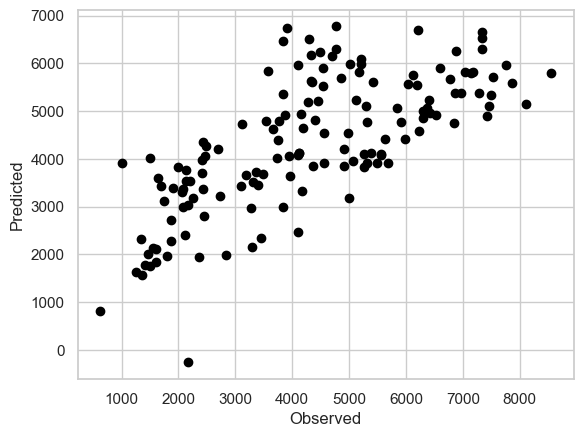

In [197]:
plt.scatter(y_test, y_test_pred,  color='black')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.show()

We'll use the root mean squared error as a performance metric to compare the observed and predicted bike counts. As the name might suggest, this is the average of the squared difference between obs and pred values.

In [198]:
from sklearn.metrics import root_mean_squared_error
print('Root mean squared error: %.2f'
      % root_mean_squared_error(y_test, y_test_pred))

Root mean squared error: 1316.78


So our prediction error from this model is approximately 1300 bikes per day. Note that your results may vary from this due to differences in random selection and model building. 


Now, we'll see if we can improve on this using a random forest model. Random forests (RFs) were first introduced by Leo Breiman to tackle very complex, noisy radar data. They work by building a series of decision trees that use the features to break the dataset down into small ranges of the outcome. For example, a decision might be that any relative humidity above 80% will have much lower values of bike rentals, or that summer months will have some of the highest counts. Each tree is based on a series of these decisions, which makes it possible to model more complex relationships, for example with these data, a tree might predict low counts at temperatures below 5 degrees, then higher counts between 5 and 20 degrees, and then low counts again. 

RF models build several hundred of these trees based on different subsets of the data, and diifferent subsets of the available features. This may seem counter-intuitive (why would you use less data to build a model?), and each individual tree is considered to be a weak model. But the ensemble of trees that are built is extremely robust to variations in the data that are used. Note that one additional advantage from this is that the RF model can provide a range of predicted outcomes (one per tree), but in practice these are usually averaged to a single value. 

Here we use scikit-learn's `RandomForestRegressor()` method from the ensemble subpackage. Scikit-learn distinguishes between methods for regression (continuous outcomes) and classification (binary or categorical outcomes). As before, we first instantiate, then fit

In [199]:
from sklearn import ensemble
rf = ensemble.RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

Now we can go through the same steps of predicting the outcome and calculating the RMSE:

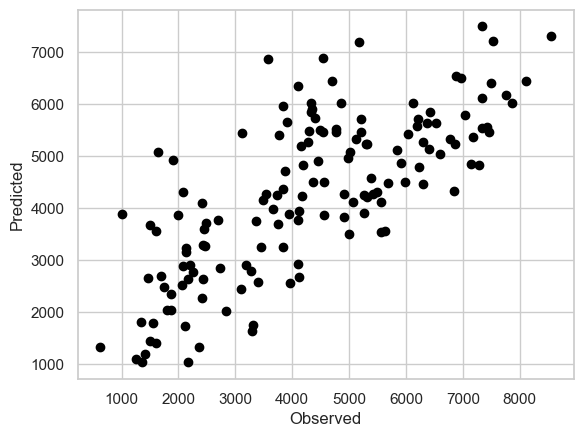

In [200]:
y_test_pred = rf.predict(X_test)
plt.scatter(y_test, y_test_pred,  color='black')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.show()


In [201]:
print('Root mean squared error: %.2f'
      % root_mean_squared_error(y_test, y_test_pred))

Root mean squared error: 1271.08


Although our predictive error is still high, it has dropped substantially from the linear model. 

## Tuning hyperparameters

Most ML algorithms have a set of hyperparameters that control the way in which the algorithm learns. For example, many algorithms use a series of iterations to update their weights, so one hyperparameter might control the number of iterations, and another might control the amount that the weights can be updated in any step. Selecting the optimal value of these, or tuning them, is often an important step in model building and may markedly improve the model skill. 

The set of hyperparameters is specific to each model. A random forest has several, but the most important are generally considered to be a) the number of features used in the decision trees and b) the number of trees that are made. The easiest way to find these to search for the relevant function on scikit-learn's website. The page for a RandomForestRegressor can be found here:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

You can also see these with the `get_params` method:

In [202]:
ensemble.RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


The two arguments we'll need are `max_features` and `n_estimators` respectively. Like most defaults, these are chosen to work reasonably well in most situations, but you can easily change them to see if it improves your model. Here, we'll re-instantiate the random forest with more trees (500) and using 4 features in each decision tree split:

In [203]:
rf = ensemble.RandomForestRegressor(max_features=4, n_estimators=500)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=4, n_estimators=500)

In [204]:
y_test_pred = rf.predict(X_test)
print('Root mean squared error: %.2f'
      % root_mean_squared_error(y_test, y_test_pred))

Root mean squared error: 1221.75


In this case, we get a small improvement in the predictive skill compared to the default settings (and this is often the case with random forests - other algorithms may show bigger changes). 

Choosing the best value for the hyperparameters can be a tedious exercise, and often a substantial part of any machine learning project, as testing every possible combination of parameters can become very time consuming. To help with this, most software allows automated tuning of the parameters. Here, the training data are split again into two subsets (one still called training and one called validation). A series of models are built using the new training set with different values for the hyperparameters, and then predicted for the validation set. The hyperparameter values that give the best performance (lowest RMSE in this example) are then considered to be optimal. Scikit-learn has a function (`GridSearchCV`) that will help with all of this. 

Let's start by defining the hyperparameter grid. This is all the values of the hyperparameters we want to test. We'll try values of `n_estimators` from 100 to 500, and `max_features` from 2 to 12:

In [205]:
rf_grid = {'n_estimators':[100, 200, 300, 400, 500],
           'max_features':[2,4,6,8,10,12]}

Next we'll set up the GridSearchCV. As before, this instantiates the function with the algorithm (), the hyperparameter grid and the performance metric (RMSE). We also need a way to split the data for training and validation. Previously, we used a holdout method to get a training and testing set. Here, we'll use a k-fold cross-validation. In this method the data are split $k$ times into a training and validation set and a model is built for each split. The size of each validation set will be $1/k$, so for a 5-fold cross-validation, each validation set is 20% of the data (the argument `cv` sets this). The advantage of this method is that we test each combination of hyperparameters $k$ times, which can provide more stable estimate of which is the best. Note that there are other methods that can be used (e.g. repeated cross-validation, bootstrapping) but are more time-consuming; $k$-fold is often preferred as it is a good balance of speed and robustness.

In [206]:
from sklearn.model_selection import GridSearchCV
rf_tuned = GridSearchCV(ensemble.RandomForestRegressor(), 
                        rf_grid, 
                        scoring='neg_root_mean_squared_error', 
                        cv=5)

Now we have this, we can set up and run the tuning process using the `fit` method. This will take a few seconds to run - it's creating 5 repeats of 30 hyperparameter values, so 150 total random forests:

In [207]:
rf_tuned.fit(X_train, y_train)
print(rf_tuned.cv_results_['mean_test_score'])

[-1208.17885247 -1208.40536973 -1208.5646123  -1208.90851041
 -1205.96507557 -1204.67693125 -1198.1651456  -1199.36300375
 -1197.4370681  -1196.96158273 -1203.99495912 -1196.60899429
 -1198.9101343  -1194.84186467 -1201.83892652 -1216.08725597
 -1211.44675929 -1205.0382328  -1197.90283593 -1201.17921542
 -1212.92255489 -1204.29199051 -1208.02969671 -1209.18823915
 -1206.96258625 -1230.69023395 -1205.42906551 -1215.02642322
 -1216.2956964  -1212.29704483]


We can get the RMSE for the best performing model:

In [208]:
print(rf_tuned.best_score_)

-1194.8418646668065


As well as the values for the hyperparameters:

In [209]:
print('Best max_features:', rf_tuned.best_estimator_.get_params()['max_features'])
print('Best n_estimators:', rf_tuned.best_estimator_.get_params()['n_estimators'])

Best max_features: 6
Best n_estimators: 400


Now's let's test the predictive skill of the selected model (the RMSE printed above is for the validation step):

In [210]:
y_test_pred = rf_tuned.predict(X_test)
print('Root mean squared error: %.2f'
      % root_mean_squared_error(y_test, y_test_pred))

Root mean squared error: 1227.84


In [169]:
rf_tuned.best_estimator_.feature_importances_

array([0.45677945, 0.16810337, 0.14199006, 0.0063897 , 0.00950855,
       0.03094027, 0.06948097, 0.00474747, 0.00725048, 0.00960333,
       0.00556685, 0.01576215, 0.01228762, 0.01869259, 0.00651009,
       0.01844968, 0.01793738])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(drop = 'first')
ohe.fit(X[categorical_features])

In [123]:
ensemble.RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Cross-validation strategy

As the majority of ML algorithms have no built in diagnostics, similar to those found in traditional statistical models, we need a different approach to assess our models. Cross-validation refers to the process of dividing the data into two subsets:

- The training set is used to build or train the model. Training selects models weights that minimize the loss function (and therefore maximize the fit of the model to the training data). 
- The test set is used to assess the model. Once the model weights have been established, the trained model is used to predict the outcome for this set. The difference between predicted and observed value is assessed using the performance metric. 

There are several different ways to create the training and test set. Here, we'll use a simple hold-out method. We use `train_test_split` to select a proportion of the original data to go into the training set (controlled by the argument `p=0.8`). This returns an index with the row number for each observation selected for training, which can then be used to create a training (`train`) and test (`test`) dataset.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.75)

Before starting building models, we need to check and clean the data. Some things that we may want to check for are:

- missing values
- variable conversions
- outliers

Let's check to see which of the features contain missing values. The following code uses a couple of methods linked together. First `isna()` to check each value in the data frame to see if it is a missing value and flag it as `True` or `False`. Then we use `any()` which returns `True` of `False` for each column if there is at least one `True` (i.e. missing) values in that column:

In [4]:
housing.isna().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

This tells us that the only column with missing values is `total_bedrooms`. We'll now remove these using the `dropna()` method to remove each row with a missing value:

In [5]:
housing = housing.dropna()
housing.shape

(20433, 10)

### Data visualization

Next, we'll visualize some of the data, starting with a quick map of the locations, then the median house values. First, we load `matplotlib` and set it to run inline in the notebook. 

In [6]:
%matplotlib inline
import matplotlib as plt

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

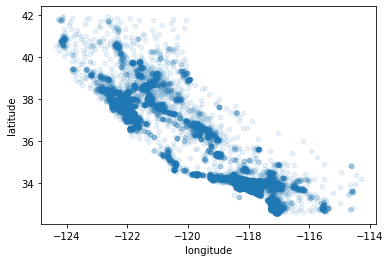

In [7]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.1)

To make a better plot of the house values, we'll use `GeoPandas`, a package that extends `Pandas` to include spatial information (you'll need to install this if you have not done so already). Now load the package, and use it to read in the California border shapefile:

In [8]:
import geopandas as gpd
ca_bnd = gpd.read_file("../datafiles/ca/ca.shp")
ca_bnd.crs

<Geographic 2D CRS: GEOGCS["GRS 1980(IUGG, 1980)",DATUM["D_unknown",SP ...>
Name: GRS 1980(IUGG, 1980)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: D_unknown
- Ellipsoid: GRS80
- Prime Meridian: Greenwich

The last line of code prints the coordinate reference system (`crs`) for the California border polygon. As the housing data is in WGS84, we can convert the polygon to this use the `to_crs()` method:

In [9]:
ca_bnd = ca_bnd.to_crs(epsg=4326)
ca_bnd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Next, we'll create a GeoPandas DataFrame from the housing data

In [10]:
housing_gpd = gpd.GeoDataFrame(housing, 
                               geometry=gpd.points_from_xy(housing.longitude, housing.latitude), 
                               crs=ca_bnd.crs)

Now let's plot the border, then add points for each location and use the `median_house_value` to set the color. Note that we first create a `base` layer, then use this when plotting the points. The `column` argument allows you to set which of the variables you want to plot:

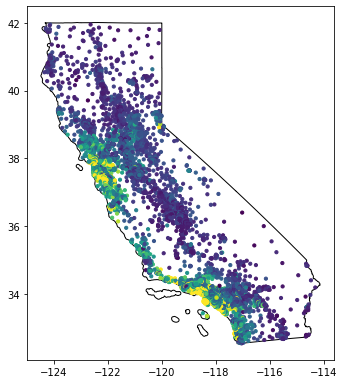

In [11]:
base = ca_bnd.plot(figsize = (6.5, 6.5), edgecolor="black", facecolor="None")
housing_gpd.plot(ax = base, column = 'median_house_value', markersize = 10);

And you should be able to clearly see the areas with high values around Los Angeles and the Bay Area. Now let's visualize the variables as a set of histograms:

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

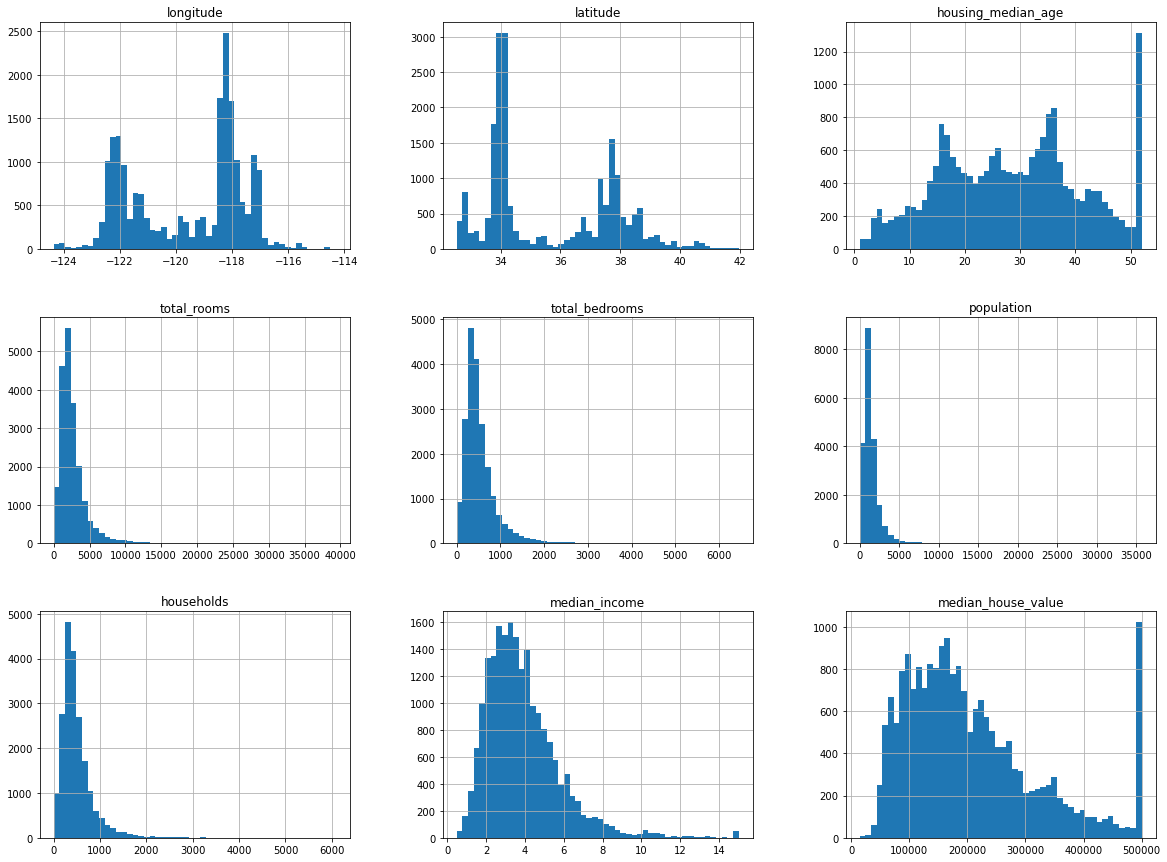

In [12]:
housing.hist(bins = 50, figsize = (20, 15))

In [13]:
housing['avg_rooms'] = housing.total_rooms / housing.households
housing['bedroom_ratio'] = housing.total_bedrooms / housing.total_rooms

As a last step here, we'll remove any observations where the house value is greater than $500K. As the dataset is capped here, these will bias our model 

In [14]:
housing2 = housing[housing.median_house_value <= 500000]

## **scikit-learn**

We'll now introduce **scikit-learn** by using it to build a simple linear regression model between the median house values and all other variables. **scikit-learn** has a standardized API for running most algorithms, and the steps we are going to take here are largely the same for any of the approaches we will look at over the next couple of weeks:

- Form a data set of features (or covariates)
- Form a data set of labels (or responses)
- Split into a *training* and *testing* dataset
- Build or train a model with the training features and labels
- Predict using the testing features
- Compare the predicted test labels to the observed test labels
- Calculate a score indicating the model performance

### Features and labels

Previous versions of **scikit-learn** were not able to use Pandas DataFrames directly, and these had to be converted to NumPy numerical arrays. Recent versions however, allow to use Pandas (this is still converted internally to a NumPy array). For our first step then, we simply need to create 

For our first model, we're only going to use a subset of the variables representing building characteristics (average number of rooms, bedroom ratio and age), so we'll create a new DataFrame with these, and a second with the house values

In [15]:
X = housing[['avg_rooms', 'bedroom_ratio', 'housing_median_age']]
y = housing['median_house_value']

### Training and testing sets

Next, we'll create a training and testing dataset. There are various approaches to do this, but for now, we'll simply use a holdout method, with 75% of the data in the training set and 25% in testing. **scikit-learn** has a function (`train_test_split`) to help with this. The argument `train_size` controls the size of the training set (here 75%). You can also set this to an integer value, in which case it will random select that number of observations for training. You can also use `test_size` if you'd prefer to control the size of the testing set

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.75)

Let's check the dimensions of our new datasets

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(15324, 3)
(15324,)
(5109, 3)
(5109,)


Giving approximately 15000 samples in training and 5000 in testing. Note that the `X` arrays have three columns representing the features, and the `y` arrays have only 1

### Training a model

We're going to use the linear regression function from **scikit-learn** (`LinearRegression()`). This is one of a set of linear models, so start by loading that module. For any scikit model, we first instantiate the model by calling the function name, then fit the model by (not too surprisingly) calling the `fit` method with the training data 

In [18]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

Having fit the model, we can check the results. First, we'll make a table of the regression coefficients:

In [19]:
print(lin_reg.coef_)

[   4298.11600975 -479380.05149738    1465.83648756]


As this is just an array of coefficients, we can make this into a table to show the corresponding features:

In [20]:
cdf = pd.DataFrame(lin_reg.coef_, X_train.columns, columns=['Coefficients'])
print(cdf)

                     Coefficients
avg_rooms             4298.116010
bedroom_ratio      -479380.051497
housing_median_age    1465.836488


Note that the coefficients do not include the intercept, so to show this:

In [21]:
print(lin_reg.intercept_)

245155.77313519455


The `score()` method will return the coefficient of determination ($R^2$). This is pretty low for this model, and in the exercise you'll look at ways to improve this.

In [22]:
print(lin_reg.score(X_train, y_train))

0.09316468555381963


### Predicting with the test set

Next step is to predict the labels or outcomes for the testing set. Prediction in **scikit-learn** is pretty straightforward, we simply call the `predict()` method on our trained model, and pass the `X_test` DataFrame.

In [23]:
y_test_pred = lin_reg.predict(X_test)

Now we can plot the predicted house values against the observed value.

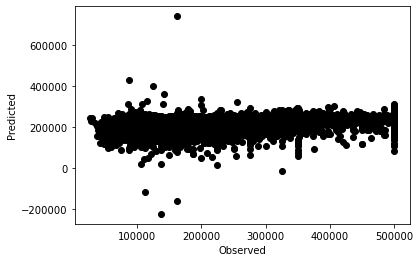

In [24]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_test_pred,  color='black')
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.show()

Note that there is a large amount of scatter on this plot (ideally, the points would fall along a 1:1 line). One thing to note here is that there are several districts where the house prices are predicted to be negative. This is obviously incorrect (unless they are paying people to take a house). Transforming the outcome variable (e.g. log transformation) would help avoid this problem. 

In addition to this visualization, we also need to quantify this using a performance score. This will eventually allow us to compare different learning algorithms or different setups of the same algorithm to see which is best. Not too surprisingly then, **scikit** comes with a whole suite of different metrics that we can use. To see the full list, go here: https://scikit-learn.org/stable/modules/model_evaluation.html

In [25]:
from sklearn.metrics import mean_squared_error
print('Root mean squared error: %.2f'
      % mean_squared_error(y_test, y_test_pred, squared = False))

Root mean squared error: 107454.46


We can easily swap this out for different metrics, e.g. the mean absolute error:

In [26]:
from sklearn.metrics import mean_absolute_error
print('Mean absolute error: %.2f'
      % mean_absolute_error(y_test, y_test_pred))

Mean absolute error: 85001.50


## Cross-validation with **scikit-learn**

So far, we have built and tested our model on a single split of the data (the hold-out method). However, if the training and testing datasets are not well set up, the estimates of model performance can be biased. There are several more exhaustive resampling strategies that can be used instead, and we will implement one of these now. This link provides a list of available strategies: https://scikit-learn.org/stable/modules/cross_validation.html

We'll just use one of the simplest, but exhaustive approaches; $k$-fold cross-validation. This splits the data into $k$ groups and loops across these. In each iteration, one group is held out as test data and the other $k-1$ are used as training data. A performance score is then estimated for each fold. **scikit** has an easy function to run this (and other approaches on a previously set up model; `cross_val_score`. 

In the following code, we first define our cross-validation strategy as a 5-fold approach, then use the following input to `cross_val_score`:

- The model object `lin_reg`
- The set of features and labels (note we use the full set as this will divide the data up for us into training and testing for each fold)
- The cross-validation strategy. The default here is a 5-fold cross-validation but being able to define our own strategy will be useful later
- The performance score (this uses the **scikit** full name)

In [27]:
from sklearn.model_selection import cross_val_score, KFold
# define model evaluation method
cv = KFold(n_splits=5)

scores = cross_val_score(lin_reg, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')

We can now print out the set of cross-validated scores (as well as calculate the mean RMSE). Note that the RMSE scores are negative (`neg_root_mean_squared_error`). By default, **scikit** tries to maximize any performance score, so making these negative means that a lower error is the effectively higher than a big error. 

In [28]:
with np.printoptions(precision=3, suppress=True):
    print(scores)
print("%.3f" % np.mean(-scores))

[-112869.036 -110355.508 -119703.455 -108338.824 -115766.569]
113406.678


## Changing model

We're going to be looking a wide range of different algorithms for machine learning over the next few weeks. This section is just designed to show how easy it is to switch out the method you are using to try a different approach. Here, we'll try using a penalized linear model, the Lasso. To test this, we simply need to import the relevant module from `sklearn.linear_model`, instantiate and run the same cross-validation strategy we previously defined. In this case, there is little improvement with this new algorithm.

In [29]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha = 1)
lasso_reg.fit(X_train, y_train)
scores = cross_val_score(lasso_reg, X, y, cv=cv, scoring = 'neg_root_mean_squared_error')
print("%.3f" % np.mean(-scores))
#print(lasso_reg.alpha_)

113406.123


## Exercise

Use a word document or jupyter notebook to record your answers and output. Assignments, to include either the word document and notebook, should be submitted to Canvas. Ensure your assignment has been saved using the following naming convention: Lab06_lastname_script and Lab06_lastname_report.

As we noted during the lab, our original model some odd effects, and had pretty poor predictive power. We'll try to improve on this by adding in extra features. The following code recreates the two DataFrames containing the features and labels, but includiing a larger set:

In [30]:
X = housing[['avg_rooms', 'bedroom_ratio', 'housing_median_age',
            'population', 'households', 'median_income']]
y = housing['median_house_value']

For the exercise, you need to 

1. Remake the basic linear model with this new dataset. Provide the following [1]:
  - The set of model coefficients
  - The value of the intercept
  - The value of the R2 for the model
2. Repeat the resampling strategy with the new task, but with a 10-fold cross validation (i.e. `n_splits=10`). Provide the set of 10 RMSE values and the aggregate RMSE [2]
3. Comment on whether you think this new model is better or worse at predictions than the mode you built in the lab [1]